Fetching S&P 500 Residuals...
Mean Return: 8.80%, Residuals Samples: 60
Running simulation...
Identifying worst-case scenario (lowest final portfolio value)...
Worst path index: 463, Final Value: $139,347.68
Plotting worst-case scenario asset allocation...


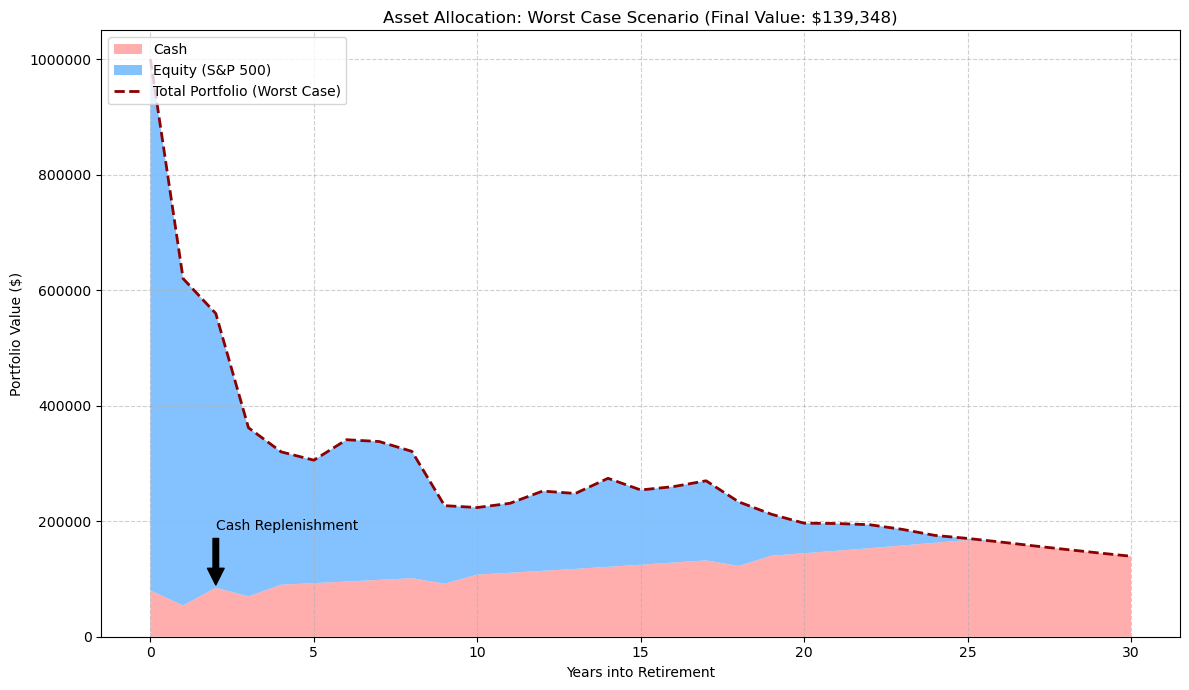

Calculating median paths...
Plotting median asset allocation...


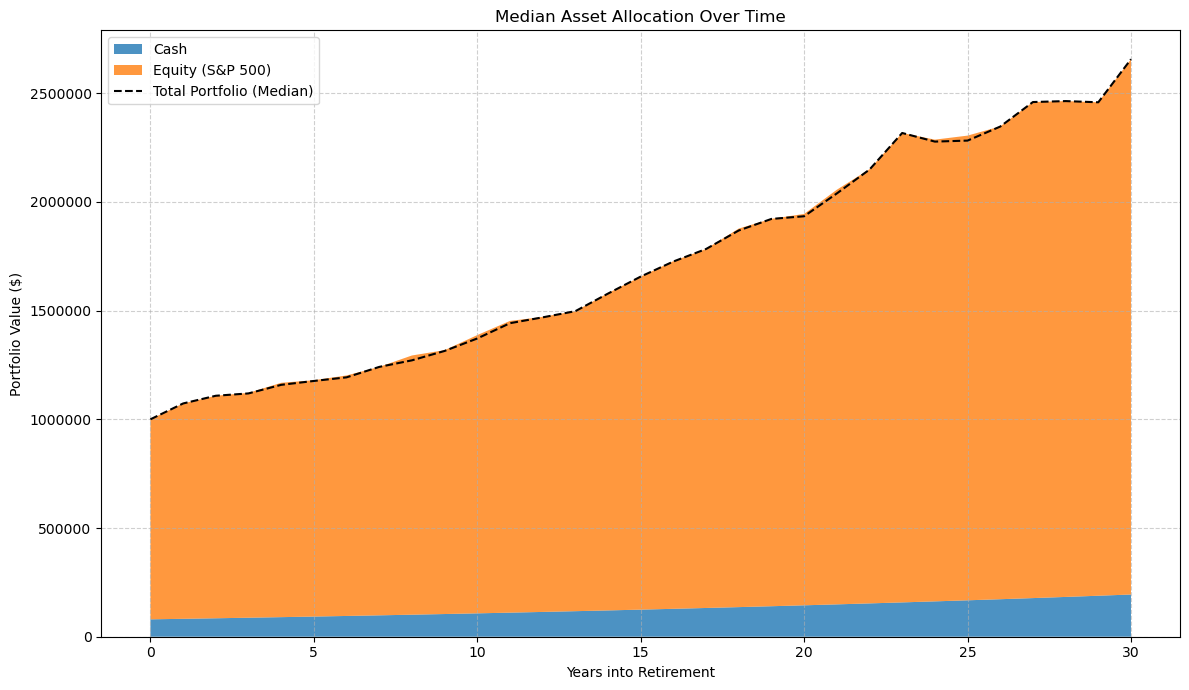

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the parent directory to the system path to import simulator
sys.path.insert(0, os.path.abspath('..'))
from simulator import run_simulation, get_sp500_residuals, create_ar_model, MeanRevertingMarket

initial_net_worth = 1_000_000
annual_spend = 40_000
buffer_years = 2
years = 30
panic_threshold = -0.15
inflation_rate = 0.03
n_paths = 500  # Reduced for quicker notebook execution
spending_cap_pct = 0.04 # 4% rule
history_years = 60 # For market data calibration

use_ar_model = False # Set to True to use AR model
ar_order = 1 # Only relevant if use_ar_model is True

if use_ar_model:
    print("Calibrating AR Model...")
    ar_model, stats_msg = create_ar_model(history_years=history_years, ar_order=ar_order)
    mu, residuals = 0.0, np.array([]) # Not used in AR mode
    print(f"AR Model Stats: {stats_msg}")
else:
    print("Fetching S&P 500 Residuals...")
    mu, residuals, _ = get_sp500_residuals(history_years)
    ar_model = None # Not used in Residuals mode
    print(f"Mean Return: {mu:.2%}, Residuals Samples: {len(residuals)}")



print("Running simulation...")
portfolio_values, withdrawals_real, cash_values, equity_values = run_simulation(
    initial_net_worth=initial_net_worth,
    annual_spend=annual_spend,
    buffer_years=buffer_years,
    years=years,
    panic_threshold=panic_threshold,
    inflation_rate=inflation_rate,
    n_paths=n_paths,
    mu=mu,
    residuals=residuals,
    use_ar_model=use_ar_model,
    ar_model=ar_model,
    spending_cap_pct=spending_cap_pct
)

# ==============================================================================
# PLOT 1: WORST-CASE SCENARIO (Lowest Final Portfolio Value)
# ==============================================================================
print("Identifying worst-case scenario (lowest final portfolio value)...")
# Find the index of the path with the lowest final portfolio value
worst_path_idx = np.argmin(portfolio_values[-1, :])
final_val = portfolio_values[-1, worst_path_idx]

print(f"Worst path index: {worst_path_idx}, Final Value: ${final_val:,.2f}")

# Extract data for the worst path
worst_equity = equity_values[:, worst_path_idx]
worst_cash = cash_values[:, worst_path_idx]
worst_total = portfolio_values[:, worst_path_idx]

# Create DataFrame for the worst path
df_worst = pd.DataFrame({
    'Year': range(years + 1),
    'Equity (S&P 500)': worst_equity,
    'Cash': worst_cash,
    'Total Portfolio': worst_total
})

print("Plotting worst-case scenario asset allocation...")
plt.figure(figsize=(12, 7))
plt.stackplot(df_worst['Year'], df_worst['Cash'], df_worst['Equity (S&P 500)'],
              labels=['Cash', 'Equity (S&P 500)'], alpha=0.8, colors=['#ff9999', '#66b3ff'])
plt.plot(df_worst['Year'], df_worst['Total Portfolio'], color='darkred', linestyle='--', linewidth=2,
         label='Total Portfolio (Worst Case)')

# Annotate Cash Replenishment
# Identify years where cash increased significantly (replenishment)
cash_diff = np.diff(worst_cash)
replenish_indices = np.where(cash_diff > 1000)[0] # Threshold to filter noise
if len(replenish_indices) > 0:
    # Annotate the first major replenishment event to keep plot clean
    first_rep_idx = replenish_indices[0] + 1 # +1 because diff is size N-1
    plt.annotate('Cash Replenishment', 
                 xy=(first_rep_idx, df_worst['Cash'][first_rep_idx]), 
                 xytext=(first_rep_idx, df_worst['Cash'][first_rep_idx] + initial_net_worth*0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10, color='black')

plt.title(f'Asset Allocation: Worst Case Scenario (Final Value: ${final_val:,.0f})')
plt.xlabel('Years into Retirement')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

# ==============================================================================
# PLOT 2: MEDIAN SCENARIO
# ==============================================================================
print("Calculating median paths...")
median_equity = np.median(equity_values, axis=1)
median_cash = np.median(cash_values, axis=1)
median_portfolio = np.median(portfolio_values, axis=1)

df_median = pd.DataFrame({
    'Year': range(years + 1),
    'Equity (S&P 500)': median_equity,
    'Cash': median_cash,
    'Total Portfolio': median_portfolio
})

print("Plotting median asset allocation...")
plt.figure(figsize=(12, 7))
plt.stackplot(df_median['Year'], df_median['Cash'], df_median['Equity (S&P 500)'],
              labels=['Cash', 'Equity (S&P 500)'], alpha=0.8)
plt.plot(df_median['Year'], df_median['Total Portfolio'], color='black', linestyle='--',
         label='Total Portfolio (Median)')

plt.title('Median Asset Allocation Over Time')
plt.xlabel('Years into Retirement')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ticklabel_format(style='plain', axis='y') # Disable scientific notation
plt.tight_layout()
plt.show()